In [ ]:
## pip install "/Users/tastraatmadja/PycharmProjects/Ilia"

In [1]:
import glob
import os
import re

from astropy import units as u
from astropy import coordinates
from astropy.io import fits
import concurrent.futures
from ilia import constants
from ilia.environment.scene import Scene
from ilia.environment.background import Background
from ilia.instrument.disperser import RomanGrism, RomanPrism, RomanFilter
from ilia.instrument.throughput import RomanEffectiveArea
from ilia.instrument.psf import getPSFFoV, StandardRomanPSF
from ilia.tools import astro, plotting
from ilia.tools import drizzle as drz
from ilia.tools.time import convertTime
from matplotlib import pyplot as plt
import numpy as np
from pysiaf.utils import rotations
from scipy import signal
import synphot as syn
import time

from scipy.interpolate import interp1d

## DEF_COORDS = coordinates.SkyCoord(7.602442990588687, -44.79116827483218, frame='icrs', unit='deg')

DEF_COORDS = coordinates.SkyCoord("04:04:57.84", "-48:25:22.8", frame='icrs', unit='deg')

ROMAN_PIXSCALE = constants.ROMAN_PIXSCALE

plotting.def_plot_values_extra_large()

In [2]:
DEF_COORDS.ra

/Users/baj/miniconda3/envs/ilia/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


<Longitude 4.08273333 deg>

In [3]:
DEF_COORDS.dec

<Latitude -48.423 deg>

In [4]:
OUTDIR = "/Users/baj/Documents/Roman/PIT/prism/hostlight_subtraction/simdata_prism_galsn"

In [5]:
delAngle   = 60.0
rollAngles = coordinates.Angle(np.arange(120.0, 180.0, delAngle), unit='deg').wrap_at(360.0 * u.deg)

In [6]:
rollAngles

<Angle [120.] deg>

In [7]:
# Set up aperture list and reference coordinates
rsiaf, roman_apertures, V2Ref_roman, V3Ref_roman, pa_y_v3 = astro.getRomanApertures()

In [ ]:
# Open the datacube where you want to insert the SN and save that
# We will use this SN added datacube instead
# load SN SED
hostsubdir = '/Users/baj/Documents/Roman/PIT/prism/hostlight_subtraction/simdata_prism_galsn'
datacubeDir = "/Users/baj/Documents/Roman/PIT/prism/vela-prism-sims"
SN = np.loadtxt(hostsubdir + '/lfnana_fnu.txt')
SN_SED = interp1d(SN[:, 0], SN[:, 1], kind='linear',
                  fill_value=0.0, bounds_error=False)

scale_factor = 10

SN_x = 117
SN_y = 73

# Open datacube to edit
dh = fits.open(datacubeDir + '/vela06_cam02_fnu.fits')
datacube = dh[1].data
wavelength = dh[2].data

datacube[:, SN_y - 1, SN_x - 1] += (scale_factor * SN_SED(wavelength))
print('Inserted SN SED at datacube coords (DS9 x, y):', SN_x, SN_y)
print('Inserted SN SED at datacube coords (row, col):', SN_y - 1, SN_x - 1)

# Save the cube with the SN
new_dh = dh
new_dh[1].data = datacube
new_dh.writeto(datacubeDir + '/vela06_cam02_fnu_SN.fits', overwrite=True)

dh.close()

Inserted SN SED at datacube coords (DS9 x, y): 117 73
Inserted SN SED at datacube coords (row, col): 72 116


In [9]:
scenes_oversample = 3 ## TYPE-IN THE OVERSAMPLING RATE OF THE SCENES HERE

datacubeFilenames = sorted(glob.glob("{0:s}/*_fnu.fits".format(datacubeDir)))

# Change the element in this list to the datacube which has the SN
for fc, fname in enumerate(datacubeFilenames):
    if 'vela06_cam02_' in fname:
        datacubeFilenames[fc] = fname.replace('fnu.fits', 'fnu_SN.fits')

print(repr(datacubeFilenames))
nDatacubeFilenames = len(datacubeFilenames)

print("Found {0:d} datacubes!".format(nDatacubeFilenames))
print("Scene oversample:", scenes_oversample)

'''
if (nDatacubeFilenames > 0):
    hduList_init = fits.open(datacubeFilenames[0])

    scenes_oversample = int(hduList_init[0].header['OVERSAMP'])

    
''';

['/Users/baj/Documents/Roman/PIT/prism/vela-prism-sims/vela01_cam08_fnu.fits', '/Users/baj/Documents/Roman/PIT/prism/vela-prism-sims/vela04_cam00_fnu.fits', '/Users/baj/Documents/Roman/PIT/prism/vela-prism-sims/vela06_cam02_fnu_SN.fits']
Found 3 datacubes!
Scene oversample: 3


In [10]:
## Creating coordinates list
coordinatesList = []

mean   = 0.0
stdDev = 50.0 

seed = 12345

np.random.seed(seed=seed)

for datacubeFilename in datacubeFilenames:
    print(datacubeFilename)

    ## Randomly generate shifts from the central coordinate
    shifts = np.random.normal(loc=mean, scale=stdDev, size=2) * u.pix

    print(shifts)
    
    c = DEF_COORDS.spherical_offsets_by(shifts[0] * ROMAN_PIXSCALE, shifts[1] * ROMAN_PIXSCALE)

    coordinatesList.append(c)

alpha = np.array([c.ra.deg for c in coordinatesList])
delta = np.array([c.dec.deg for c in coordinatesList])

/Users/baj/Documents/Roman/PIT/prism/vela-prism-sims/vela01_cam08_fnu.fits
[-10.23538297  23.9471669 ] pix
/Users/baj/Documents/Roman/PIT/prism/vela-prism-sims/vela04_cam00_fnu.fits
[-25.97193575 -27.78651522] pix
/Users/baj/Documents/Roman/PIT/prism/vela-prism-sims/vela06_cam02_fnu_SN.fits
[98.28902863 69.67029165] pix


In [11]:
coordinatesList

[<SkyCoord (ICRS): (ra, dec) in deg
     (4.08226207, -48.42226828)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (4.08153748, -48.42384903)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (4.0872587, -48.4208711)>]

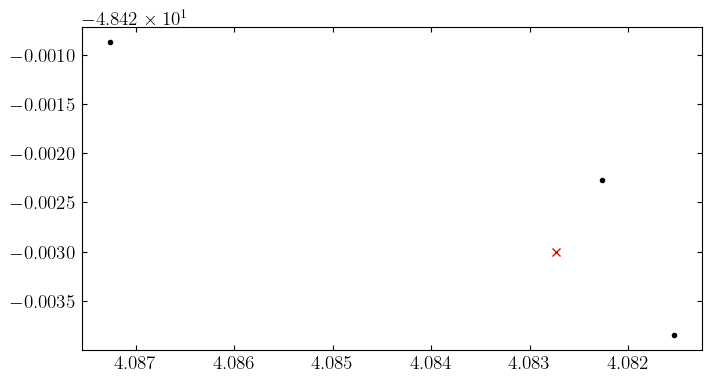

In [12]:
xSize = 8
ySize = 8

plotting.def_plot_values_extra_large()

fig, ax = plt.subplots(figsize=(xSize, ySize))

ax.plot(DEF_COORDS.ra, DEF_COORDS.dec, 'rx')

for c in coordinatesList:
    ax.plot(c.ra, c.dec, 'k.')

ax.set_aspect('equal')

ax.xaxis.set_inverted(True)

In [13]:
fig.clear()
plt.close(fig)
del fig

In [14]:
constants.V2_REF, constants.V3_REF

(1546.3846181707652, -892.7916365721071)

1312.9491452484797 -1040.7853726755036
1 3 13 4.333333333333333
120.0 300.0 240.0 WFI01_FULL [ True] [ True  True  True]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

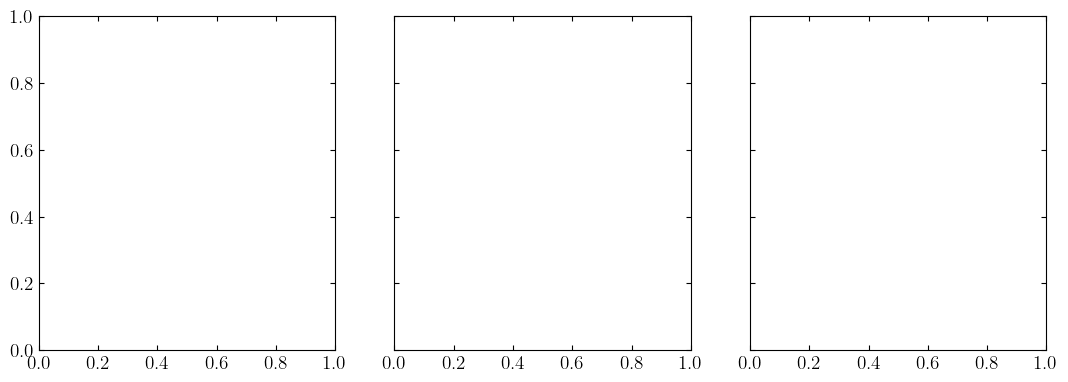

In [15]:
## Find the central coordinates of SCA01 in the v2-v3 plane
wfi01_v2, wfi01_v3 = roman_apertures[0].idl_to_tel(0, 0)

print(wfi01_v2, wfi01_v3)

## Now we plot the detector orientations as a function of roll angle, i.e. the position angle between -x axis and the positive RA axis, measured positive towards NORTH
nCols = 3
nRows = int(np.ceil(rollAngles.size / nCols))

xSize = 13
ySize = nRows * xSize / nCols

print(nRows, nCols, xSize, ySize)

showLabel = False

factor = 800.0

## Now we rotate the detector around this point and plot
fig, axes = plt.subplots(figsize=(xSize, ySize), ncols=nCols, nrows=nRows, sharex=True, sharey=True)

for i in range(nRows):
    for j in range(nCols):
        k = np.ravel_multi_index((i,j), (nRows,nCols))

        if (k < rollAngles.size):
            rollAngle = rollAngles[k]
            pa_v3     = (360.0 * u.deg - pa_y_v3 - rollAngle).wrap_at(360.0 * u.deg)
            pa_aper   = (pa_y_v3 + pa_v3).wrap_at(360.0 * u.deg)
            
            att = rotations.attitude(wfi01_v2, wfi01_v3, DEF_COORDS.ra, DEF_COORDS.dec, pa_v3)

            for aperture in roman_apertures:
                aperture.set_attitude_matrix(att)

                pointing_idl, in_footprint_pointing = astro.footprintContains(aperture, DEF_COORDS.ra, DEF_COORDS.dec, 'idl')
                coords_idl, in_footprint_coords     = astro.footprintContains(aperture, alpha, delta, 'idl')

                if (in_footprint_pointing.any() and in_footprint_coords.any()):
                    print(rollAngle.value, pa_v3.value, pa_aper.value, aperture.AperName, in_footprint_pointing, in_footprint_coords)

                    axes[i,j].plot(pointing_idl[:,0], pointing_idl[:,1], 'rx')
                    axes[i,j].plot(coords_idl[:,0], coords_idl[:,1], 'k.')

            axes[i,j].text(0.05, 0.95, '${0:0.0f}^\circ$'.format(rollAngle.value), ha='left', va='top', transform=axes[i,j].transAxes)

        else:
            axes[i,j].set_visible(False)

axCommon = plotting.drawCommonLabel(r'$X$ [arcsec]', r'$Y$ [arcsec]', fig, xPad=20, yPad=45)

plt.subplots_adjust(wspace=0.0, hspace=0.0)

plt.savefig('test_rollAngle_multipleGalaxies.png', bbox_inches='tight', dpi=300)

print("ALL DONE!")

In [16]:
for coordinate, datacubeFilename in zip(coordinatesList, datacubeFilenames):
    print(coordinate, datacubeFilename)

<SkyCoord (ICRS): (ra, dec) in deg
    (4.08226207, -48.42226828)> /Users/baj/Documents/Roman/PIT/prism/vela-prism-sims/vela01_cam08_fnu.fits
<SkyCoord (ICRS): (ra, dec) in deg
    (4.08153748, -48.42384903)> /Users/baj/Documents/Roman/PIT/prism/vela-prism-sims/vela04_cam00_fnu.fits
<SkyCoord (ICRS): (ra, dec) in deg
    (4.0872587, -48.4208711)> /Users/baj/Documents/Roman/PIT/prism/vela-prism-sims/vela06_cam02_fnu_SN.fits


In [ ]:
subtractBackground = True

nCPUs = None

exposureTime = 900.0 * u.s

filterNames = ['F106', 'prism']

nPP_PSF, nQQ_PSF = 51, 51
oversample_PSF   = scenes_oversample ## MUST BE SAME AS THE OVERSAMPLING RATE OF THE SCENE!

nP_PSF, nQ_PSF = nPP_PSF * oversample_PSF, nQQ_PSF * oversample_PSF

nWX_PSF = 2 * nQ_PSF - 1
nWY_PSF = 2 * nP_PSF - 1

FoV_PSF = getPSFFoV(nP_PSF, nQ_PSF, oversample_PSF)

print(FoV_PSF)

print("Loading PSF...")
PSF = StandardRomanPSF(FoV_PSF, oversample_PSF)

print("Loading throughputs...")
AEff = RomanEffectiveArea(pandeia=False, useNew=True)

bg = Background()

startTimeAll = time.time()
for rollAngle in rollAngles:
    pa_v3     = (360.0 * u.deg - pa_y_v3 - rollAngle).wrap_at(360.0 * u.deg)
    pa_aper   = (pa_y_v3 + pa_v3).wrap_at(360.0 * u.deg)

    ## Point the 
    att = rotations.attitude(wfi01_v2, wfi01_v3, DEF_COORDS.ra, DEF_COORDS.dec, pa_v3)

    for filterName in filterNames:
        weight = 1.0 / scenes_oversample
        if (filterName == 'grism'):
            disperser = RomanGrism(oversample=scenes_oversample, centered=True)
        elif (filterName == 'prism'):
            disperser = RomanPrism(oversample=scenes_oversample, centered=True)
        else:
            disperser = RomanFilter()
            weight    = 1.0
            
        wavePix    = disperser.getWavelengthPixels()
        pixCoords  = disperser.getPixelCoordinates()
        dispersion = disperser.getDispersionCurve()

        print("Resampling PSF...")
        psf       = PSF.getResampledPSF(wavePix)
        effArea   = AEff.getEffectiveArea(wavePix, filterName)
        nonZeroes = np.argwhere(effArea > 0).flatten()

        print(psf.shape)

        bgPhotonRate = (syn.units.convert_flux(wavePix, bg.getBackground(wavePix, oversample=scenes_oversample), syn.units.PHOTLAM) * effArea * dispersion / scenes_oversample).decompose()
        
        bgRate = bgPhotonRate.sum().value * (scenes_oversample ** 2) * u.adu / u.s

        print("BG rate:", bgRate)

        ## Set the pointing. Add a sub-pixel randomness to the pointing
        randomShiftAlpha = (-1.0 + 2.0*np.random.rand()) * u.pix
        randomShiftDelta = (-1.0 + 2.0*np.random.rand()) * u.pix

        ## Pointing is the coordinates plus randomnes
        pointing = DEF_COORDS.spherical_offsets_by(randomShiftAlpha * ROMAN_PIXSCALE, randomShiftDelta * ROMAN_PIXSCALE)

        ## Calculate the attitude matrix given. Input is where we want to center the detectors (in this case
        ## it is the center of WFI01, the pointing coordinates, and the roll angle
        att = rotations.attitude(wfi01_v2, wfi01_v3, pointing.ra, pointing.dec, pa_v3)

        ## Cycle over all the detectors
        for aperture in roman_apertures:
            aperture.set_attitude_matrix(att)

            ## Given the RA and DEC of the objects, get the ideal detector coordinates for THIS detector
            ## as well as the whether it is in the footprint of the detector
            coords_idl, in_footprint_coords = astro.footprintContains(aperture, alpha, delta, 'idl')

            ## IF ANY OF THESE COORDINATES ARE IN THE FOOTPRINT, THEN WE'RE IN BUSINESS AND WE CAN START SIMULATING
            if in_footprint_coords.any():
                print(pointing.ra, pointing.dec, rollAngle.value, pa_v3.value, pa_aper.value, aperture.AperName, in_footprint_coords[in_footprint_coords].size)
        
                psfDrizzleMatrix = drz.getAreaFractionMatrix(psf.shape[2], psf.shape[1], 0, 0, pa_aper, 
                                                             constants.ROMAN_PIXSCALE / float(oversample_PSF), 
                                                             nXOut=nWX_PSF, nYOut=nWY_PSF, oversample=1)
        
                naxis1, naxis2 = aperture.XSciSize, aperture.YSciSize
                crpix1, crpix2 = aperture.XSciRef, aperture.YSciRef
    
                ## This is how we transform the crpix1, crpix2 coordinate, which is a 1-indexed, full-integer image grid,
                ## into the coordinate of a zero-indexed, half-integer grid (the grid of pypolyclip)
                xCOut, yCOut = crpix1 - 0.5, crpix2 - 0.5
        
                downsample = 1.0 / float(scenes_oversample)
    
                specRate = np.zeros((naxis2, naxis1))
    
                def dropImage(thisScene, dx, dy, angle):
                    nP, nQ = thisScene.nP, thisScene.nQ
                    thisScene.resampleScene(wavePix)
                    if (filterName != 'grism') and (filterName != 'prism'):
                        drzMatrix = drz.getAreaFractionMatrix(nQ, nP, dx, dy, angle, constants.ROMAN_PIXSCALE / float(scenes_oversample), 
                                                              nXOut=naxis1, nYOut=naxis2, xCOut=xCOut, yCOut=yCOut, oversample=downsample)
                    
                    thisSpecRate = np.zeros((naxis2, naxis1))
                    for l in range(wavePix.size):
                        rotatedPSF     = (psfDrizzleMatrix @ np.nan_to_num(psf[l]).flatten()).reshape((nWY_PSF, nWX_PSF))
                        convolvedImage = thisScene.getConvolvedResampledMonochromaticSlice(l, rotatedPSF)
                        
                        photonRate = (convolvedImage * effArea[l] * dispersion[l] * weight).decompose()
                        photonRate = (photonRate * 1.0 * u.adu / u.ph).decompose() ## Conversion rate from photon to ADU
        
                        if (filterName == 'grism') or (filterName == 'prism'):
                            shiftY_arcsec = pixCoords[l] * constants.ROMAN_PIXSCALE
                            drzMatrix     = drz.getAreaFractionMatrix(nQ, nP, dx, dy + shiftY_arcsec, angle, 
                                                                      constants.ROMAN_PIXSCALE / float(scenes_oversample), nXOut=naxis1, nYOut=naxis2, 
                                                                      xCOut=xCOut, yCOut=yCOut, oversample=downsample)
    
                        thisSpecRate += np.nan_to_num((drzMatrix @ np.nan_to_num(photonRate).flatten()).reshape((naxis2, naxis1)))
                    return thisSpecRate
    
                startTime = time.time()
                with concurrent.futures.ThreadPoolExecutor(max_workers=nCPUs) as executor:
                    futures = []
    
                    for coordinate, datacubeFilename in zip(coordinatesList, datacubeFilenames):
                        print(coordinate, datacubeFilename)
    
                        hduList = fits.open(datacubeFilename)
                        # print('Opening:', datacubeFilename)
    
                        # datacube   = np.array(hduList[0].data, dtype=float) * u.Unit(hduList[0].header['BUNIT'].lower())
                        # wavelength = np.array(hduList[1].data['wavelength'], dtype=float) * u.Unit(hduList[1].header['TUNIT1'].lower())
    
                        datacube   = hduList[1].data.astype(np.float32) * syn.units.FNU
                        wavelength = hduList[2].data.astype(np.float32) * u.angstrom
                        oversample = 3
                        wavelength = wavelength[350:680]
                        datacube = datacube[350:680,:,:]

                        scene = Scene(datacube, wavelength, oversample=scenes_oversample)
    
                        x, y = aperture.sky_to_idl(coordinate.ra, coordinate.dec)
    
                        x *= u.arcsec
                        y *= u.arcsec
    
                        print(x, y, rollAngle)
    
                        futures.append(executor.submit(dropImage, scene, x, y, rollAngle))
    
                    print("Number of jobs:", len(futures))
        
                    for future in concurrent.futures.as_completed(futures):
                        specRate += future.result()
                
                ## Make values positive so that random poisson generator does not break
                specRate = np.nan_to_num(np.clip(specRate, a_min=0, a_max=None))
    
                specRate *= u.adu / u.s
    
                noisySpec = np.random.poisson((specRate + bgRate).value * exposureTime.value) * u.adu
    
                if subtractBackground:
                    noisySpec -= bgRate * exposureTime
                
                stdDev = np.sqrt((specRate + bgRate) * exposureTime).value * u.adu
                
                alpha0, delta0 = aperture.idl_to_sky(0,0)
                wcs = astro.getWCS(rollAngle, filterName, naxis2, naxis1, alpha=alpha0, delta=delta0, crpix1=crpix1, crpix2=crpix2, oversample=1)
    
                hduListOut = []
    
                header = fits.Header()
                header['COMMENT'] = "Simulated Roman 2d spectra generated using Ilia"
                header['COMMENT'] = "https://gitlab.com/astraatmadja/Ilia"
        
                hduListOut.append(fits.PrimaryHDU(header=header))

                hduListOut[0].header.set('DATE', value=time.strftime('%Y-%m-%d'), comment='date this file was written (yyyy-mm-dd)')
    
                image_hdu = fits.ImageHDU(noisySpec.value, name='SCI', ver=1)
                image_hdu.header.set('TELESCOP', aperture.observatory)
                image_hdu.header.set('INSTRUME', aperture.InstrName)
                image_hdu.header.set('APERTURE', aperture.AperName)
                image_hdu.header.set('SCA_NUM', int(re.sub("[^0-9]", "", aperture.AperName)))
                image_hdu.header.set('FILTER', "{0:s}".format(filterName), 'filter')
                image_hdu.header.set('BUNIT', str(noisySpec.unit), 'brightness units')
                image_hdu.header.set('exptime', exposureTime.value, 'exposure time in sec')
                image_hdu.header.set('ORIENTAT', pa_aper.deg)
                image_hdu.header.set('PA_V3', pa_v3.deg)
                image_hdu.header.set('BG_RATE', bgRate.value, 'sky background rate in ADU/s')
                image_hdu.header.update(wcs.to_header())
    
                hduListOut.append(image_hdu)
    
                stdDevImage_hdu = fits.ImageHDU(stdDev.value, name='ERR', ver=1)
                stdDevImage_hdu.header.set('TELESCOP', aperture.observatory)
                stdDevImage_hdu.header.set('INSTRUME', aperture.InstrName)
                stdDevImage_hdu.header.set('APERTURE', aperture.AperName)
                stdDevImage_hdu.header.set('SCA_NUM', int(re.sub("[^0-9]", "", aperture.AperName)))
                stdDevImage_hdu.header.set('FILTER', "{0:s}".format(filterName), 'filter')
                stdDevImage_hdu.header.set('BUNIT', str(noisySpec.unit), 'brightness units')
                stdDevImage_hdu.header.set('exptime', exposureTime.value, 'exposure time in sec')
                stdDevImage_hdu.header.set('ORIENTAT', pa_aper.deg)
                stdDevImage_hdu.header.set('PA_V3', pa_v3.deg)
                stdDevImage_hdu.header.set('BG_RATE', bgRate.value, 'sky background rate in ADU/s')
                stdDevImage_hdu.header.update(wcs.to_header())
    
                hduListOut.append(stdDevImage_hdu)
    
                DQImage_hdu = fits.ImageHDU(np.ones(noisySpec.shape, dtype=np.int16), name='DQ', ver=1)
                DQImage_hdu.header.set('TELESCOP', aperture.observatory)
                DQImage_hdu.header.set('INSTRUME', aperture.InstrName)
                DQImage_hdu.header.set('APERTURE', aperture.AperName)
                DQImage_hdu.header.set('SCA_NUM', int(re.sub("[^0-9]", "", aperture.AperName)))
                DQImage_hdu.header.set('FILTER', "{0:s}".format(filterName), 'filter')
                DQImage_hdu.header.set('BUNIT', "unitless", 'brightness units')
                DQImage_hdu.header.set('exptime', exposureTime.value, 'exposure time in sec')
                DQImage_hdu.header.set('ORIENTAT', pa_aper.deg)
                DQImage_hdu.header.set('PA_V3', pa_v3.deg)
                DQImage_hdu.header.set('BG_RATE', bgRate.value, 'sky background rate in ADU/s')
                DQImage_hdu.header.update(wcs.to_header())
    
                hduListOut.append(DQImage_hdu)
    
                image_hduNF = fits.ImageHDU((specRate * exposureTime).value, name='TRUE', ver=1)
                image_hduNF.header.set('TELESCOP', aperture.observatory)
                image_hduNF.header.set('INSTRUME', aperture.InstrName)
                image_hduNF.header.set('APERTURE', aperture.AperName)
                image_hduNF.header.set('SCA_NUM', int(re.sub("[^0-9]", "", aperture.AperName)))
                image_hduNF.header.set('FILTER', "{0:s}".format(filterName), 'filter')
                image_hduNF.header.set('BUNIT', str(noisySpec.unit), 'brightness units')
                image_hduNF.header.set('exptime', exposureTime.value, 'exposure time in sec')
                image_hduNF.header.set('ORIENTAT', pa_aper.deg)
                image_hduNF.header.set('PA_V3', pa_v3.deg)
                image_hduNF.header.set('BG_RATE', bgRate.value, 'sky background rate in ADU/s')
                image_hduNF.header.update(wcs.to_header())
    
                hduListOut.append(image_hduNF)
    
                hduList = fits.HDUList(hduListOut)
    
                hduList.info()
    
                outFilename = "{0:s}/test_2d_multipleGalaxies_{1:s}_{2:s}_{3:s}_rollAngle{4:03.0f}.fits".format(OUTDIR, aperture.InstrName, aperture.AperName, filterName, rollAngle.deg)
            
                hduList.writeto(outFilename, overwrite=True)
    
                print("Image written to {0:s}".format(outFilename))
    
                print("DONE! ELAPSED TIME:", convertTime(time.time() - startTime))

print("ALL DONE! ELAPSED TIME:", convertTime(time.time() - startTimeAll))

15.0 arcsec
Loading PSF...
Loading throughputs...
Resampling PSF...
(2049, 411, 411)
BG rate: 0.2098973497492946 adu / s


/Users/baj/miniconda3/envs/ilia/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


4d04m57.99399213s -48d25m22.76630101s 120.0 300.0 240.0 WFI01_FULL 3
<SkyCoord (ICRS): (ra, dec) in deg
    (4.08226207, -48.42226828)> /Users/baj/Documents/Roman/PIT/prism/vela-prism-sims/vela01_cam08_fnu.fits
-2.8661430815631865 arcsec -0.23670797297658352 arcsec 120d00m00s
<SkyCoord (ICRS): (ra, dec) in deg
    (4.08153748, -48.42384903)> /Users/baj/Documents/Roman/PIT/prism/vela-prism-sims/vela04_cam00_fnu.fits


/Users/baj/miniconda3/envs/ilia/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/baj/miniconda3/envs/ilia/lib/python3.10/site-packages/ilia/tools/interpolation.py:83: RuntimeWarning: divide by zero encountered in divide
  return sparse.spdiags(np.nan_to_num(1.0 / (a @ w)).reshape((1, -1)), 0) @ a @ sparse.spdiags(w.reshape((1, -1)), 0)


1.1966806919168893 arcsec 4.107814060901573 arcsec 120d00m00s
<SkyCoord (ICRS): (ra, dec) in deg
    (4.0872587, -48.4208711)> /Users/baj/Documents/Roman/PIT/prism/vela-prism-sims/vela06_cam02_fnu_SN.fits
-1.2530883164766546 arcsec -13.0899338793588 arcsec 120d00m00s
Number of jobs: 3
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1  SCI           1 ImageHDU        38   (4088, 4088)   float64   
  2  ERR           1 ImageHDU        38   (4088, 4088)   float64   
  3  DQ            1 ImageHDU        38   (4088, 4088)   int16   
  4  TRUE          1 ImageHDU        38   (4088, 4088)   float64   
Image written to /Users/baj/Documents/Roman/PIT/prism/hostlight_subtraction/simdata_prism_galsn/test_2d_multipleGalaxies_WFI_WFI01_FULL_F106_rollAngle120.fits
DONE! ELAPSED TIME: 0 h 16 m 21.404 s
Resampling PSF...
(624, 411, 411)
BG rate: 2.0204619930315286 adu / s
4d04m57.6923931

/Users/baj/miniconda3/envs/ilia/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


<SkyCoord (ICRS): (ra, dec) in deg
    (4.08226207, -48.42226828)> /Users/baj/Documents/Roman/PIT/prism/vela-prism-sims/vela01_cam08_fnu.fits
-2.85194828278696 arcsec -0.4596293107670735 arcsec 120d00m00s
<SkyCoord (ICRS): (ra, dec) in deg
    (4.08153748, -48.42384903)> /Users/baj/Documents/Roman/PIT/prism/vela-prism-sims/vela04_cam00_fnu.fits
1.210870767167152 arcsec 3.8848971637534384 arcsec 120d00m00s
<SkyCoord (ICRS): (ra, dec) in deg
    (4.0872587, -48.4208711)> /Users/baj/Documents/Roman/PIT/prism/vela-prism-sims/vela06_cam02_fnu_SN.fits
-1.2388795330986646 arcsec -13.312853487082105 arcsec 120d00m00s
Number of jobs: 3


/Users/baj/miniconda3/envs/ilia/lib/python3.10/site-packages/ilia/tools/interpolation.py:83: RuntimeWarning: divide by zero encountered in divide
  return sparse.spdiags(np.nan_to_num(1.0 / (a @ w)).reshape((1, -1)), 0) @ a @ sparse.spdiags(w.reshape((1, -1)), 0)


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1  SCI           1 ImageHDU        38   (4088, 4088)   float64   
  2  ERR           1 ImageHDU        38   (4088, 4088)   float64   
  3  DQ            1 ImageHDU        38   (4088, 4088)   int16   
  4  TRUE          1 ImageHDU        38   (4088, 4088)   float64   
Image written to /Users/baj/Documents/Roman/PIT/prism/hostlight_subtraction/simdata_prism_galsn/test_2d_multipleGalaxies_WFI_WFI01_FULL_prism_rollAngle120.fits
DONE! ELAPSED TIME: 0 h 7 m 59.039 s
ALL DONE! ELAPSED TIME: 0 h 27 m 32.776 s


: 